## Setting the environment

In [213]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

In [214]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [215]:
from keras_preprocessing.sequence import pad_sequences

## Loading dataset

In [216]:
data = pd.read_csv("hello.csv")

In [217]:
# Dataset exploration

data.shape

(50000, 2)

In [237]:
data.head(5)

,text,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: xlabel='sentiment', ylabel='count'>

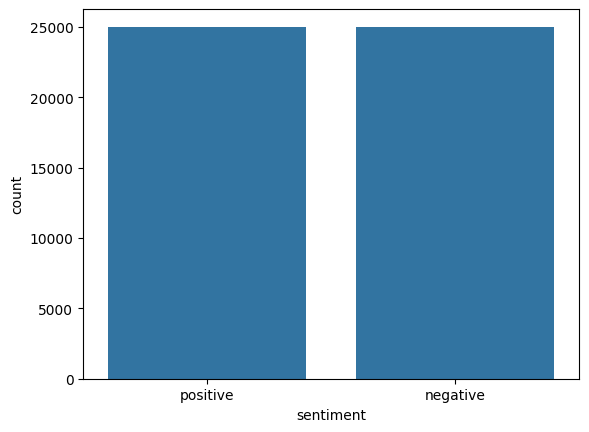

In [220]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=data)

In [221]:
# Checking for missing values

data.isnull().values.any()

False

## Data Preprocessing

In [160]:
data["text"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [241]:
custom = CustomPreprocess()
custom.preprocess_text("Those were the best days of my life!")

'best days life '

In [240]:
import re
import nltk
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)
    

class CustomPreprocess():
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()
        
        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
        
        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
        
        return sentence

In [165]:
import pandas as pd

data = pd.read_csv('hello.csv')
import pandas as pd

# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values
data = data.dropna()

# Now proceed with your preprocessing
X = []
sentences = list(data['text'])
for sen in sentences:
    X.append(custom.preprocess_text(sen))


text         0
sentiment    0
dtype: int64


In [166]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [170]:
# Converting sentiment labels to 0 & 1

y = data['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Preparing embedding layer

In [172]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [173]:
import io
import json

In [174]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [175]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [176]:
# Padding all text to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [177]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [178]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [180]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## Simple Neural Network

In [181]:
# Neural Network architecture
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))


In [182]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [183]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 5ms/step - loss: 0.5553 - acc: 0.7163 - val_loss: 0.5045 - val_acc: 0.7615
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4486 - acc: 0.7977 - val_loss: 0.4954 - val_acc: 0.7681
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4123 - acc: 0.8170 - val_loss: 0.5018 - val_acc: 0.7656
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3919 - acc: 0.8265 - val_loss: 0.5104 - val_acc: 0.7635
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3730 - acc: 0.8368 - val_loss: 0.5193 - val_acc: 0.7641
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3634 - acc: 0.8423 - val_loss: 0.5295 - val_acc: 0.7574


In [184]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5588 - acc: 0.7494


In [185]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5587945580482483
Test Accuracy: 0.7494000196456909


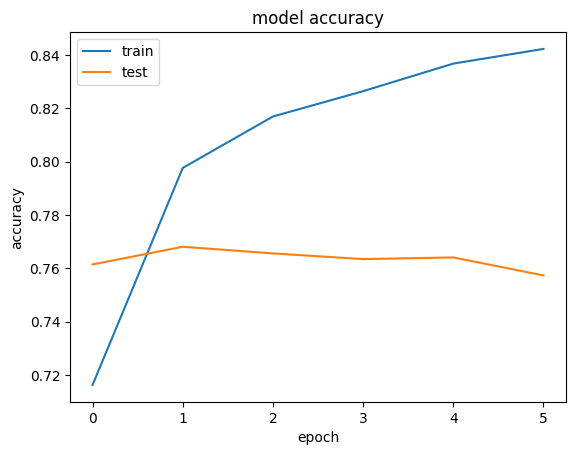

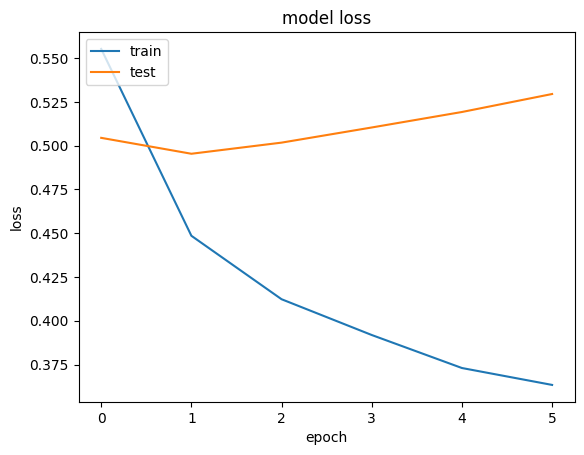

In [186]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [187]:
from keras.layers import LSTM

In [188]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [189]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [190]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 38s 141ms/step - loss: 0.5331 - acc: 0.7367 - val_loss: 0.4389 - val_acc: 0.7989
Epoch 2/6
250/250 [==============================] - 32s 128ms/step - loss: 0.4144 - acc: 0.8166 - val_loss: 0.3895 - val_acc: 0.8342
Epoch 3/6
250/250 [==============================] - 33s 132ms/step - loss: 0.3664 - acc: 0.8424 - val_loss: 0.3495 - val_acc: 0.8489
Epoch 4/6
250/250 [==============================] - 35s 139ms/step - loss: 0.3423 - acc: 0.8546 - val_loss: 0.3415 - val_acc: 0.8495
Epoch 5/6
250/250 [==============================] - 35s 140ms/step - loss: 0.3221 - acc: 0.8655 - val_loss: 0.3230 - val_acc: 0.8606
Epoch 6/6
250/250 [==============================] - 33s 133ms/step - loss: 0.3058 - acc: 0.8744 - val_loss: 0.3181 - val_acc: 0.8666


In [191]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 8s 25ms/step - loss: 0.3190 - acc: 0.8626


In [192]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3190290629863739
Test Accuracy: 0.8626000285148621


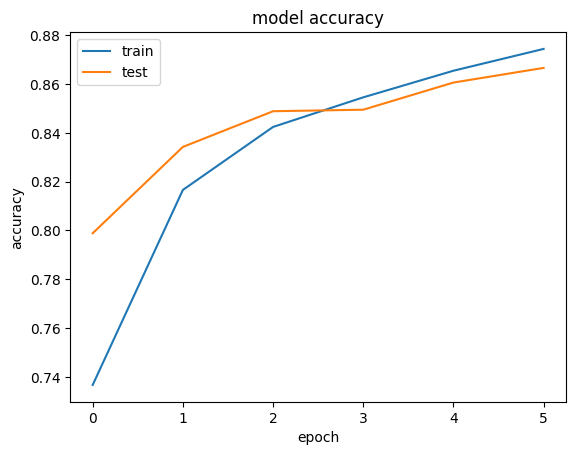

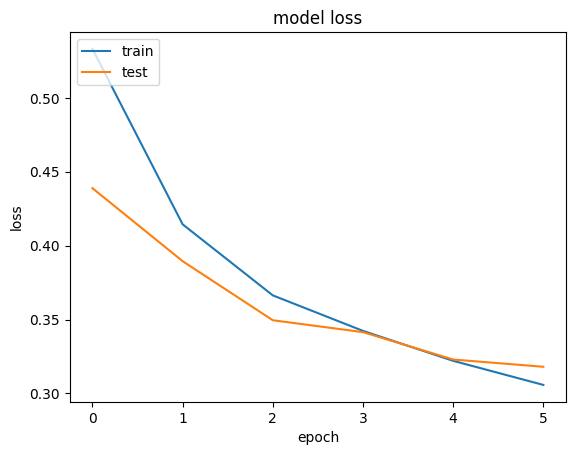

In [193]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [194]:
lstm_model.save(f"./full_model_{round(score[1], 3)}.h5", save_format='h5')

C:\Users\strop\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [195]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='full_model.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.
pretrained_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [196]:
sample = pd.read_csv("predict.csv")

sample.head()

,Text
0,This tutorial was so helpful! Thanks a bunch
1,"Ugh, I've been struggling with this for hours...."
2,Your energy is contagious! Loved every minute ...
3,Why does this always happen to me?
4,"Wow, this is a game-changer! Can't believe I d..."


In [242]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your pre-trained LSTM model
model = load_model('full_model.h5')

# Load the dataset to be predicted
dataset = pd.read_csv('predict.csv')

texts = dataset['Text'].tolist()

# Tokenize the text using the same tokenizer used during training
tokenizer_path = 'b3_tokenizer.json'
with open(tokenizer_path, 'r') as f:
    tokenizer_config = json.load(f)

tokenizer = tokenizer_from_json(tokenizer_config)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to match the expected input shape of your LSTM model
max_sequence_length = 100  
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Make predictions
predictions = model.predict(padded_sequences)

# Convert probabilities to class labels (binary classification)
class_labels = (predictions > 0.5).astype(int)

# Map class labels to sentiment categories (0 for negative, 1 for positive)
predicted_sentiments = class_labels.flatten()

# Create a new column in the dataset to store the predicted sentiment labels
dataset['predicted_sentiment'] = predicted_sentiments

# Save the updated dataset with predicted sentiment labels
dataset.to_csv('predicted_dataset.csv', index=False)

# Display the first few rows of the updated dataset
print(dataset.head(9))


2/2 [==============================] - 2s 34ms/step
                                                Text  predicted_sentiment
0       This tutorial was so helpful! Thanks a bunch                    1
1  Ugh, I've been struggling with this for hours....                    0
2  Your energy is contagious! Loved every minute ...                    1
3                 Why does this always happen to me?                    1
4  Wow, this is a game-changer! Can't believe I d...                    1
5  I can't stop watching your videos. You make le...                    0
6  The music in the background is distracting. Pl...                    0
7  I tried this recipe, and it turned out amazing...                    1
8         The ads are way too long. Losing interest.                    0
